In [31]:
import os
import pandas as pd

import sklearn.ensemble as ske
import matplotlib.pylab as plt
%matplotlib inline

from bounos.Analyses.Weight import summed_outliers_per_weight

def categorise_dataframe(df):
    # Categories work better as indexes
    for obj_key in df.keys()[df.dtypes == object]:
        try:
            df[obj_key] = df[obj_key].astype('category')
        except TypeError:
            print("Couldn't categorise {}".format(obj_key))
            pass
    return df

def non_zero_rows(df):
    return df[~(df==0).all(axis=1)]

The questions we want to answer are:
1. What metrics differentiate between what behaviours
2. Do these metrics cross over domains (i.e. comms impacting behaviour etc)

To answer these questions we first have to manipulate the raw dataframe to be weight-indexed with behaviour(`var`) keys on the perspective from the observer to the (potential) attacker in a particular run (summed across the timespace)

While this analysis simply sums both the upper and lower outliers, **this needs extended/readdressed**

# IMPORTANT 
The July 3rd Simulation Run had a small mistake where the Ran

In [135]:
observer = 'Bravo'
target = 'Alfa'
n_nodes = 6
n_metrics = 9

results_path = "/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2015-07-03-16-45-26"
results_path = "/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2015-07-20-17-47-53"
shared_h5_path = '/dev/shm/shared.h5'
#Something smells
#shared_h5_path = '/home/bolster/src/aietes/results/shared.bkup.h5'
fig_basedir = "/home/bolster/src/thesis/papers/active/16_AAMAS"


with pd.get_store(shared_h5_path) as store:
    joined_target_weights = store.get('joined_target_weights')
    joined_feats = store.get('joined_feats')
    comms_only_feats = store.get('comms_only_feats')
    phys_only_feats = store.get('phys_only_feats')
    comms_only_weights = store.get('comms_only_weights')
    phys_only_weights = store.get('phys_only_weights')

joined_feat_weights = categorise_dataframe(non_zero_rows(joined_feats).T)
comms_feat_weights = categorise_dataframe(non_zero_rows(comms_only_feats).T)
phys_feat_weights = categorise_dataframe(non_zero_rows(phys_only_feats).T)

KeyError: 'No object named joined_target_weights in the file'

In [171]:
with pd.get_store(results_path + "/outliers.bkup.h5") as store:
    weight_df = store.get(store.keys()[0])
#weight_df

In [143]:
from bounos.Analyses.Weight import target_weight_feature_extractor
import itertools
#from bounos.Analyses.Weight import generate_weighted_trust_perspectives
from bounos.Analyses import Trust
with pd.get_store(results_path + '.h5') as store:
    #trust_observations = store.trust.xs('Bravo',level='observer', drop_level=False).dropna()
    # Testing if using the full set initially improves things...
    trust_observations = store.trust.dropna()


def generate_weighted_trust_perspectives(trust_observations, feat_weights, par=True):  
    weighted_trust_perspectives = []
    for w in feat_weights:
        weighted_trust_perspectives.append(Trust.generate_node_trust_perspective(
            trust_observations,
            metric_weights=pd.Series(w),
            par=par
        ))

    return weighted_trust_perspectives
    
def drop_metrics_from_weights_by_key(target_weights, drop_keys):
    reset_by_keys = target_weights.reset_index(level=drop_keys)
    zero_indexes = (reset_by_keys[drop_keys] == 0.0).all(axis=1)
    dropped_target_weights = reset_by_keys[zero_indexes].drop(drop_keys, 1)
    return dropped_target_weights

weight_df = joined_target_weights
comms_weights = drop_metrics_from_weights_by_key(weight_df, ['INDD', 'INHD', 'Speed'] )
feats = target_weight_feature_extractor(comms_weights, raw=True)


CombinedBadMouthingPowerControl
CombinedSelfishTargetSelection
CombinedTrust
Shadow
SlowCoach


In [141]:
for base_str, reg_list in feats.items():
    print(base_str)
    if base_str != "CombinedTrust":
        continue
    for target_str, reg in reg_list:
        if target_str == base_str:
            continue
        else:
            print("---"+target_str)

CombinedTrust
---CombinedBadMouthingPowerControl
---CombinedSelfishTargetSelection
---Shadow
---SlowCoach
Shadow
CombinedBadMouthingPowerControl
SlowCoach
CombinedSelfishTargetSelection


In [77]:
phys_keys = ['INDD', 'INHD', 'Speed']
comm_keys = ['ADelay', 'ARXP', 'ATXP', 'RXThroughput', 'TXThroughput', 'PLR']
target_str = 'CombinedSelfishTargetSelection'
for target, reg in feats['CombinedTrust']:
    if target == target_str:
        f = reg.feature_importances_
        print np.sum(f)
        
_inner = lambda x: map(np.nanmean,np.split(x, [1], axis=1))
assess = lambda x: -np.subtract(*_inner(x))
assess_run = lambda x: assess(x.xs(0,level='run').values)

combinations = [f * i for i in itertools.product([-1,1],repeat=6)]

#pd.Series(combinations[0])
basic_weight = Trust.generate_node_trust_perspective(
    trust_observations[comm_keys].xs(target_str, level='var'), 
    metric_weights=pd.Series(f))
basic_score = assess_run(basic_weight)
if np.abs(basic_score)<0.5:
    print("Crappy run {}".format(basic_score))
    perspectives = generate_weighted_trust_perspectives(trust_observations[comm_keys].xs(target_str, level='var'),
                                                    combinations, par=True)


1.0
Crappy run 0.0038015757877


In [133]:
group_keys, assessments = zip(*map(best_group_in_perspective,perspectives))
len(f)

6

In [123]:
from collections import defaultdict
best_weight = combinations[np.argmax(assessments)]
best_run = group_keys[np.argmax(assessments)]
best = defaultdict(dict)
best['test'][target_str] = (best_run, best_weight)
best['another'][target_str] = (best_run, best_weight)

best_run, best_weight = best['test'][target_str]
from aietes.Tools import mkcpickle, uncpickle

bool(mkcpickle('test',dict(best)))
moar = uncpickle('test')
moar['another']['CombinedSelfishTargetSelection'][0]

True

In [76]:
def best_group_in_perspective(perspective):
    test_group = perspective.groupby(level=['observer','run']).apply(assess)
    best_group = test_group.argmax()
    return best_group,test_group[best_group]

In [90]:
with pd.get_store(results_path + '.h5') as store:
    test_trust_observations = store.trust.dropna()
test_weight = Trust.generate_node_trust_perspective(
    test_trust_observations[comm_keys].xs(target_str, level='var'), 
    metric_weights=pd.Series(best_weight))
#plot_result(pd.stats.moments.ewma(test_weight, span=6), stds=False)

In [91]:
test_group = test_weight.groupby(level=['observer','run']).apply(assess)
best_group = test_group.argmax()
test_group[best_group]

0.13748458176859096

            Alfa      Bravo    Charlie      Delta       Echo
count  55.000000  58.000000  59.000000  59.000000  59.000000
mean    0.402062   0.552896   0.551923   0.553042   0.500550
std     0.280841   0.280323   0.269299   0.261668   0.278018
min     0.058845   0.079466   0.058314   0.052890   0.059571
25%     0.153113   0.322605   0.320113   0.322777   0.286212
50%     0.293059   0.588843   0.631211   0.638196   0.497071
75%     0.660520   0.811817   0.733974   0.753527   0.736088
max     0.947110   0.947110   0.947110   0.894091   0.947110


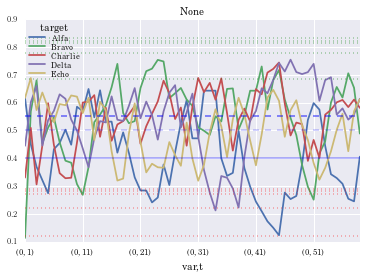

In [92]:
plot_result(test_weight\
            .xs(best_group, level=['observer','run'])\
            .dropna(axis=1, how='all'), stds=True, spans=6)

In [74]:
def plot_result(result, title=None, stds=True, spans=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    if spans is not None:
        pd.stats.moments.ewma(result, span=spans).plot(ax=ax)
    else:
        result.plot(ax=ax, alpha=0.3)

    def pltstd(tup):
        mean, std = tup
        ax.axhline(mean + std, alpha=0.3, ls=':', color='green')
        ax.axhline(mean - std, alpha=0.3, ls=':', color='red')

    for i,v in enumerate(result.mean()):
        if i:
            ax.axhline(v, alpha=0.2, ls='--', color='blue')
        else:
            ax.axhline(v, alpha=0.3, ls='-', color='blue')
    if stds:
        map(pltstd, zip(result.mean(), result.std()))
    ax.set_title(title)
    print(result.describe())
    plt.show()
perspectives.groupby(level=['observer','run']).apply(assess)

[target                   Alfa     Bravo   Charlie     Delta      Echo  \
 var run observer t                                                      
 0   0   Alfa     1        NaN       NaN  0.396936  0.845086  0.208377   
                  2        NaN  0.116615  0.412900  0.689619  0.938673   
                  3        NaN  0.836428  0.808613  0.294678  0.557590   
                  4        NaN  0.283998       NaN  0.415592  0.737333   
                  5        NaN  0.141474  0.128125  0.677136  0.358805   
                  6        NaN  0.154914       NaN  0.676275  0.894744   
                  7        NaN  0.622498       NaN  0.111446  0.845086   
                  8        NaN  0.467464       NaN  0.258339  0.207930   
                  9        NaN  0.559077  0.133961       NaN  0.819612   
                  10       NaN  0.698770  0.875250       NaN  0.238865   
                  11       NaN  0.295030  0.890386       NaN  0.420544   
                  12       NaN  0.8846

In [131]:
best_comms_runs = uncpickle(fig_basedir+'/best_comms_runs')


IOError: [Errno 2] No such file or directory: '/home/bolster/src/thesis/papers/active/16_AAMAS/best_comms_runs'

In [ ]:
# Single DataFrame of all features against known good
var_weights = target_weights.apply(lambda s: s/target_weights.CombinedTrust, axis=0).dropna()
known_good_features = \
    pd.concat([feature_extractor(s.reset_index(),var) for var,s  in var_weights.iteritems()],
              keys=var_weights.keys(), names=['var','metric'])

These results handily confirm that there is a 'signature' of badmouthing as RandomFlatWalk was incorrectly configured. 

Need to: 
1. Perform multi-run tolerance analysis of metrics (i.e. turn the below into a boxplot)
2. Perform cross correlation analysis on metrics across runs/behaviours (what metrics are redundant)

In [ ]:
_=known_good_features.unstack().plot(kind='bar')

In [ ]:
_=known_good_features.unstack().boxplot()

In [ ]:
import operator

def target_weight_feature_extractor(target_weights):
    known_good_features_d = {}
    for basekey in target_weights.keys(): # Parallelisable
        print basekey
        # Single DataFrame of all features against one behaviour
        var_weights = target_weights.apply(lambda s: s/target_weights[basekey], axis=0).dropna()
        known_good_features_d[basekey] = \
            pd.concat([feature_extractor(s.reset_index(),var) for var,s  in var_weights.iteritems()],
                      keys=var_weights.keys(), names=['var','metric'])
            
    return known_good_features_d


def dataframe_weight_filter(df, keys):
    indexes = [(df.index.get_level_values(k)==0.0) for k in keys]
    return df.loc[reduce(operator.and_,indexes)]

phys_keys = ['INDD','INHD','Speed']
comm_keys = ['ADelay','ARXP','ATXP','RXThroughput','TXThroughput','PLR']

In [ ]:
#Comms Only Weights
comms_target_weights=dataframe_weight_filter(target_weights,phys_keys)
comms_target_weights.reset_index(level=phys_keys, drop=True, inplace=True)
comms_features_d = target_weight_feature_extractor(comms_target_weights)
for var,feat in comms_features_d.iteritems():
    feat.unstack().plot(kind='bar', title=var)

In [ ]:
#Phys Only Weights
phys_target_weights=dataframe_weight_filter(target_weights,comm_keys)
phys_target_weights.reset_index(level=comm_keys, drop=True, inplace=True)
phys_features_d = target_weight_feature_extractor(phys_target_weights)
for var,feat in phys_features_d.iteritems():
    feat.unstack().plot(kind='bar', title=var)